In [1]:
# 대조발산 사용해서 이미지를 생성 -> 로그분포의 그레이디언트를 직접 추정해서 모델을 학습
# 원시데이터에 여러 스케일의 잡음을 적용 NCSN(noise conditional score network)
# 2020년에 논문-->확산모델
# GAN에 필적할 만한 모델 DDPM(denoising diffusion probabilitics model)


In [2]:
# 원본
# https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset

# 구글드라이브 공유
# https://drive.google.com/file/d/1jrATCAQQaYTu0dzUOruC2ZZWQ-BeY9Ig/view?usp=sharing

# 소스코드 위치
# https://keras.io/examples/generative/ddpm/

In [ ]:
!unzip '/content/drive/MyDrive/Oxford 102 Flower Dataset/Oxford 102 Flower Dataset.zip'

In [4]:
from glob import glob
imglists = glob('/content/dataset/**/*')
imglists_sample = glob('/content/dataset/test/*.jpg')
imglists_sample[:5]

['/content/dataset/test/image_04277.jpg',
 '/content/dataset/test/image_01599.jpg',
 '/content/dataset/test/image_03048.jpg',
 '/content/dataset/test/image_06351.jpg',
 '/content/dataset/test/image_07434.jpg']

In [9]:
from myutils import display, sample_batch

In [ ]:
import matplotlib.pylab as plt
import matplotlib.image as mpimg
image = mpimg.imread(imglists_sample[0])
plt.imshow(image)

잡음제거  확산모델
  - 연속해서 매우 조금씩 이미지에서 잡을을 제거하도록 모델을 훈련
  - 데이터셋에서 정방향(잡음추가)과 역방향(잡음제거)확산과정

In [10]:
from tensorflow.keras import utils

In [15]:
train_data = utils.image_dataset_from_directory(
    '/content/dataset/',
    labels=None,
    image_size=(64,64),
    batch_size = None,
    shuffle=True,
    seed=42,
)

Found 8189 files belonging to 1 classes.


In [16]:
import tensorflow as tf

In [17]:
# 데이터 전처리
def preprocess(img):
  img = tf.cast(img,'float32') / 255.0
  return img

In [ ]:
train = train_data.map(lambda x : preprocess(x))  # 픽셀값을 0과 1사이로 조정
train = train.repeat(5)  # 데이터를 5번 반복
train = train.batch(64,drop_remainder=True)  # 배치로 데이터를 나눌때 64보다 작을때 남는데이터 무시

In [ ]:
# 이미지를 여러단계에 걸처서(T1000번) 점진적으로 손상시켜서 가우스 표준잡음과 구별할수 없도록 만든다.
# 이미지에 분산 bi를 갖는 소량의 가우스 잡음을 추가해서 새로운 이미지를 생성하는 함수 q를 정의 이 함수를 계속적용

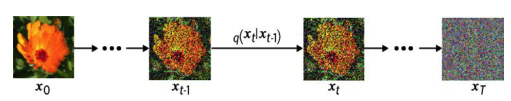

In [18]:
# 각 스텝마다 다른 bi를 자유롭게 선택 bi값이 T에 따라 변하는 방식을 확산스케줄
# 논문에서는 선형확산스케줄  bi가 0.0001 ~ 0.02까지 선형적으로 변환다
# 잡음 추가과정의 초기단계에서 후기단계보다 잡음이 적게 추가

In [19]:
# 확산스케줄
def linear_diffusion_schedule(diffusion_times):  # diffusion_times 확산단계의 수
  min_rate = 0.0001
  max_rate = 0.02
  # 각 단계에서 확산 속도를 계산 min_rate에서 시작해서 max_rate로 선형적으로 증가
  betas = min_rate + tf.convert_to_tensor(diffusion_times) * (max_rate - min_rate)
  alphas = 1-betas # betas의 역수   가 단계에서의 신호 속도
  alpha_bars = tf.math.cumprod(alphas) # alphas의 누적 곱, 간 단계에서 전체 누적신호 속도
  signal_rates = alphas
  noise_rates = 1-alpha_bars # 각 단계에서의 noise 속도
  return noise_rates,signal_rates

In [ ]:
T = 1000
diffusion_times = [x/T for x in range(T)]  # 확산 시간은 0과 1 사이에서 동일한 간격으로 나눈 값
diffusion_times

In [22]:
linear_noise_rates, linear_signal_rates =  linear_diffusion_schedule(diffusion_times)

In [23]:
linear_noise_rates[:3], linear_signal_rates[:3]

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.00010002, 0.00021994, 0.00035965], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.9999   , 0.9998801, 0.9998602], dtype=float32)>)

In [ ]:
# 코사인 확산 스케줄 : 선형스케줄보다 성능이 우수
# 삼각 함수 항등식  코사인제곱 + 사인제곱 = 1

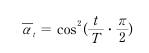

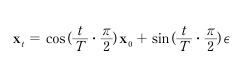

In [ ]:
# 코사인 확산 스케줄, 오프셋 코사인 확산 스케줄
# 확산과정 초기에 잡음 추가가 너무 적게 되지 않도록 오프셋 항과 스케일링을 추가해서 구현
import math
def cosine_deffusion_schedule(diffusion_times):
  signal_rates = tf.cos(diffusion_times*math.pi / 2)
  noise_rates = tf.sin(diffusion_times*math.pi / 2)
  return noise_rates,signal_rates
def offset_cosine_diffusion_schedule(diffusion_times):
  min_signal_rate = 0.02
  max_signal_rate = 0.95
  start_angle = tf.acos(max_signal_rate) # 각도
  end_angle=tf.acos(min_signal_rate) # 각도
  diffusion_angles = start_angle + diffusion_times*(end_angle - start_angle)
  signal_rates = tf.cos(diffusion_angles)
  noise_rates = tf.sin(diffusion_angles)
  return noise_rates, signal_rates